# Setup

In [219]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [751]:
matplotlib.rcParams['font.size'] = 6.5
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['savefig.pad_inches'] = 0.05
matplotlib.rcParams['savefig.bbox'] = 'tight'

In [752]:
figure_path = '../figures/'

In [753]:
model_list = [
    'random', 
    'stockfish_score', 
    'nn_moves_no_stockfish',
    'transformer_moves_no_stockfish',
    'linear_moves', 
    'nn_moves', 
    'transformer_moves', 
    'nn_board',
    'transformer_board',
    'nn_all',
    'transformer_all'
]

model_features_pretty = [
    'Random', 
    'SF', 
    'Moves - SF',
    'Moves - SF',
    'Moves', 
    'Moves', 
    'Moves', 
    'Board',
    'Board',
    'All',
    'All'
]

# Load Data

In [80]:
model_files = {model: '../data/test_results_%s.csv' % model for model in model_list}

In [81]:
model_dfs = {model: pd.read_csv(model_files[model]) for model in model_list}

# Analyze Results

In [265]:
def get_predictions(df):
    p_model = df[df['move_played'] == 1]['p_model']
    return p_model

In [607]:
def get_moves_played(df):
    return df[df['move_played'] == 1]['move_uci'].values

In [610]:
def get_moves_predicted(df):
    df_grouped = df.groupby('id_board', sort=False)
    
    moves_played = []
    for group, df_group in df_grouped:
        label = np.argmax(df_group['p_model'].values)
        moves_played.append(df_group['move_uci'].values[label])
    return np.array(moves_played)

In [568]:
def get_prediction_ranks(df):
    df_grouped = df.groupby('id_board')
    ret = []
    moves_played = []
    for group, df_group in df_grouped:
        p_model = df_group['p_model'].values
        label = np.argmax(df_group['move_played'].values)
        rank = np.argsort(np.argsort(p_model)[::-1])[label]
        ret.append(rank)
        
    return np.array(ret), moves_played

In [569]:
model_nll_list = {model: -np.log(get_predictions(model_dfs[model])) for model in model_list}
model_avg_nll = {model: np.average(model_nll_list[model]) for model in model_nll_list}

In [570]:
print(model_avg_nll)

{'random': 3.18135760405986, 'stockfish_score': 2.9749734932767766, 'nn_moves_no_stockfish': 2.7833901750135572, 'transformer_moves_no_stockfish': 2.6930097328123064, 'linear_moves': 2.589448842847644, 'nn_moves': 2.180958732568152, 'transformer_moves': 2.104055508827916, 'nn_board': 2.225847198406077, 'transformer_board': 2.1251432877308574, 'nn_all': 2.2414126965120516, 'transformer_all': 2.124026326976132}


In [554]:
model_rank_list = {model: get_prediction_ranks(model_dfs[model]) for model in model_list}

In [292]:
print(np.sum(np.array(model_rank_list['nn_board']) < 2) / 4949)

0.050717316629622144


# Plots: Results for All Models

In [754]:
c_base   = '#aaaaaa'
c_linear = '#ee6666'
c_nn     = '#5555ee'
c_tf     = '#44ee44'

plt_x = [-0.5, 1, 3, 4, 6, 7, 8, 10, 11, 13, 14]
plt_c = [c_base] * 2 + [c_nn, c_tf] + [c_linear, c_nn, c_tf] + [c_nn, c_tf] * 2
plt_xticks = [-0.5, 1, 3.5, 7, 10.5, 13.5]
plt_xtick_labels = ['Random', 'SF', 'No SF', 'Moves', 'Board', 'All']

In [820]:
def plot_nll(ax):
    plt_y = [model_avg_nll[model] for model in model_list]
    
    ax.bar(plt_x, plt_y, color=plt_c, zorder=2)
    ax.set_xticks(plt_xticks)
    ax.set_xticklabels(plt_xtick_labels, rotation='vertical', rotation_mode='anchor', ha='right', va='center')
    ax.set_yticks(np.arange(2, 3.4, 0.2))
    ax.set_ylim(1.9, 3.2)
    ax.set_title('Average NLL', fontsize=7)
    ax.grid(axis='y')

In [821]:
def plot_top_k(ax, k, ylim):
    plt_y = [np.average(model_rank_list[model] < k)*100 for model in model_list]
    
    ax.bar(plt_x, plt_y, color=plt_c, zorder=2)
    ax.set_xticks(plt_xticks)
    ax.set_xticklabels(plt_xtick_labels, rotation='vertical', rotation_mode='anchor', ha='right', va='center')
    (y_min, y_max) = ylim
    ax.set_ylim(y_min, y_max)
    ax.set_title('Top %d Accuracy (%%)' % k, fontsize=7)
    ax.grid(axis='y')

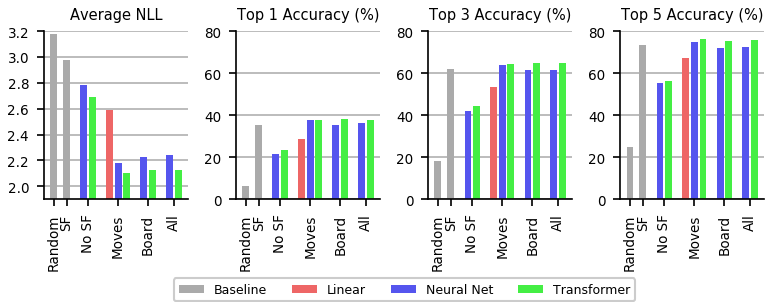

In [822]:
fig, ax_list = plt.subplots(1, 4, figsize=(6.2, 2))
plot_nll(ax_list[0])
plot_top_k(ax_list[1], 1, (0, 80))
plot_top_k(ax_list[2], 3, (0, 80))
plot_top_k(ax_list[3], 5, (0, 80))

for ax in ax_list:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

legend_elements = [
    Patch(facecolor=c_base,   label='Baseline'),
    Patch(facecolor=c_linear, label='Linear'),
    Patch(facecolor=c_nn,     label='Neural Net'),
    Patch(facecolor=c_tf,     label='Transformer'),
]

fig.subplots_adjust(bottom=0.32, wspace=0.33)
fig.legend(handles=legend_elements, facecolor='white', framealpha=1, loc='upper center', bbox_to_anchor=(0.435, 0.1), fontsize=6, ncol=4)
plt.savefig(figure_path + 'model_results.pdf')
plt.show()

# Model Analysis

## Build Model Dataframe

In [406]:
df = model_dfs['transformer_board']
df = df.join(df_stockfish['p_model'].rename('p_sf'), 'id_board')
df_stockfish = model_dfs['stockfish_score']

In [425]:
ranks = df.groupby('id_board').apply(lambda x: get_prediction_ranks(x)[0])
ranks_stockfish = df_stockfish.groupby('id_board').apply(lambda x: get_prediction_ranks(x))

In [426]:
df_board = df.dropna()
df_board = df_board.join(ranks.rename('rank_model').apply(lambda x: x[0]), 'id_board')
df_board = df_board.join(ranks_stockfish.rename('rank_sf').apply(lambda x: x[0]), 'id_board')
df_ranks = df_board

In [427]:
print(get_predictions(df).values[:40])

[0.19575657 0.38794452 0.7871675  0.44717845 0.4951406  0.0177431
 0.18432097 0.20319091 0.03644016 0.17195018 0.03105962 0.5510265
 0.12001196 0.18686453 0.60688895 0.13666202 0.27777365 0.03285531
 0.93072563 0.09307795 0.17974544 0.04837427 0.3563893  0.06728714
 0.0983781  0.2398598  0.39301533 0.05063229 0.05791973 0.54482126
 0.16060647 0.20039175 0.8092585  0.10585921 0.21565978 0.16124281
 0.09717986 0.4200072  0.6059502  0.11198638]


In [681]:
df_ranks['p_model'] = get_predictions(df).values
df_ranks['p_sf']    = get_predictions(df_stockfish).values
df_ranks['move_uci_model'] = get_moves_predicted(df)
df_ranks['move_uci_sf'] = get_moves_predicted(df_stockfish)
df_ranks['move_uci_played'] = get_moves_played(df)

In [683]:
display(df_ranks[['id_board', 'rank_model', 'rank_sf', 'p_model', 'p_sf', 'move_uci_model', 'move_uci_played', 'move_uci_sf']])

,id_board,rank_model,rank_sf,p_model,p_sf,move_uci_model,move_uci_played,move_uci_sf
0,20909,0,4,0.195757,0.056335,b4d4,b4d4,g5f4
21,2990,0,0,0.387945,0.035082,f3e5,f3e5,f3e5
55,9996,0,0,0.787168,0.033330,e5f6,e5f6,e5f6
107,23706,0,0,0.447178,0.054250,e2e4,e2e4,e2e4
127,3103,1,0,0.495141,0.501177,g1f1,g1h1,g1h1
...,...,...,...,...,...,...,...,...
142188,6454,1,1,0.349784,0.295253,g8h8,e5f7,g8h8
142192,14207,1,1,0.194377,0.258066,e3d2,h5h6,e3d2
142198,15234,0,0,0.901870,0.050586,c6a8,c6a8,c6a8
142239,2183,3,8,0.079619,0.024908,g5h4,c2c3,g5h4


## Specific Positions

In [644]:
print('comparing model vs sf:')
display(sum(df_ranks['rank_model'] <  df_ranks['rank_sf'] - 15))
display(sum(df_ranks['rank_model'] <  df_ranks['rank_sf']))
display(sum(df_ranks['rank_model'] == df_ranks['rank_sf']))
display(sum(df_ranks['rank_model'] >  df_ranks['rank_sf']))
display(sum(df_ranks['rank_model'] >  df_ranks['rank_sf'] + 15))

print('bad model moves:')
display(sum(df_ranks['rank_model'] >  35))
display(sum(df_ranks['p_model'] < 0.0002))
display(sum(df_ranks['p_model'] > 0.99))
# display(sum(df_ranks['rank_sf'] >  35))

comparing model vs sf:


49

1633

2025

1291

10

bad model moves:


12

12

71

In [637]:
bad_rows = df_ranks['p_model'] < 2e-4
bad_fens = df_ranks[bad_rows]['board_fen']
bad_moves_predicted = df_ranks[bad_rows]['move_uci_model']
bad_moves_played = df_ranks[bad_rows]['move_uci_played']
# print(bad_rows)
# print(bad_fens)

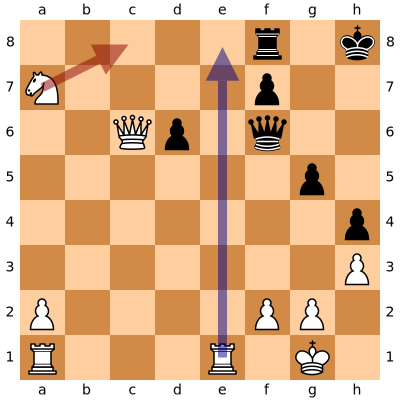

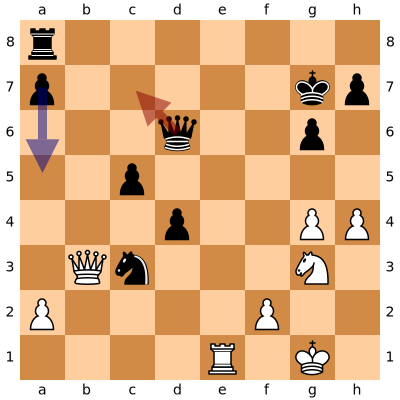

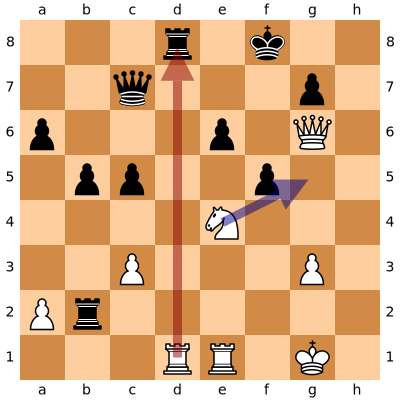

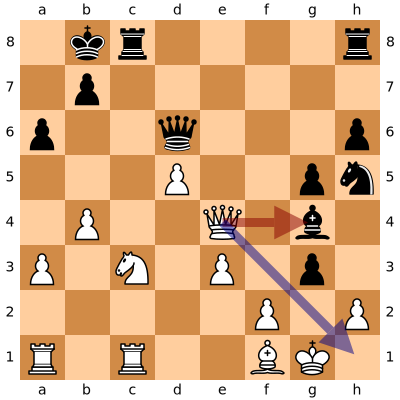

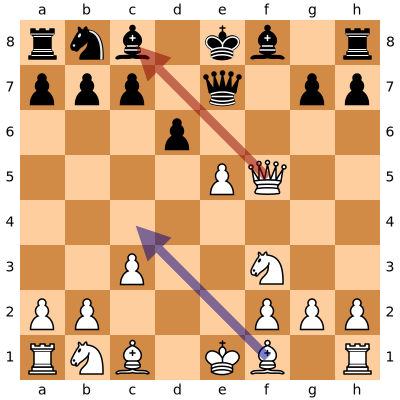

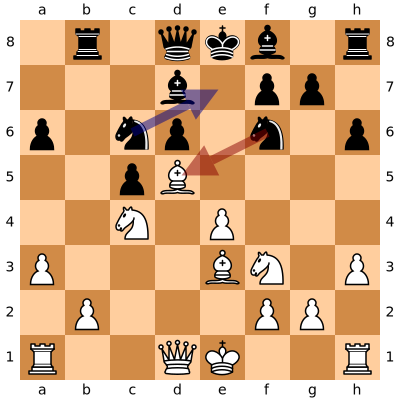

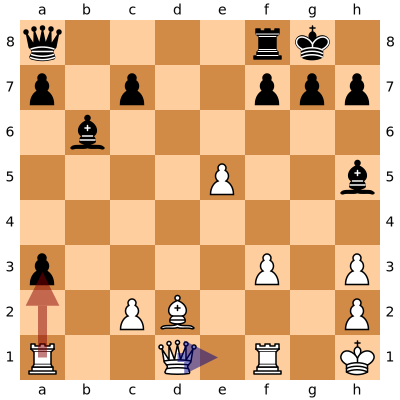

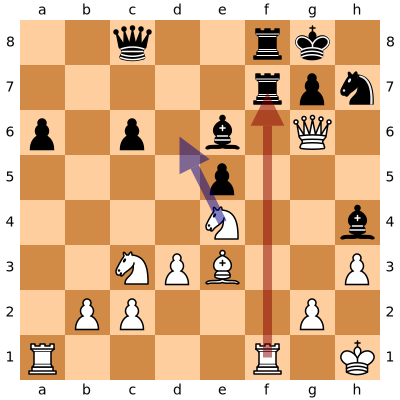

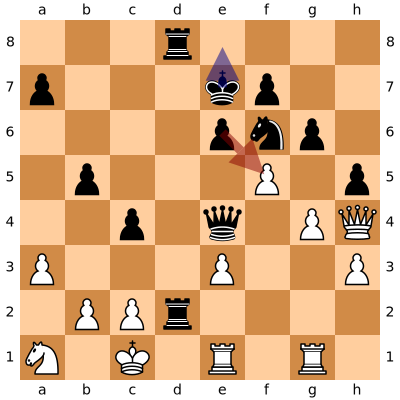

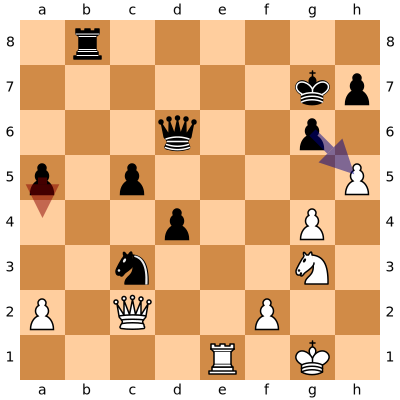

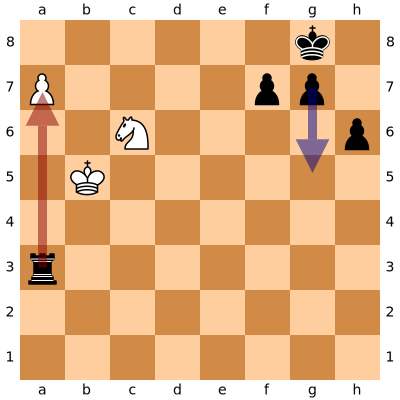

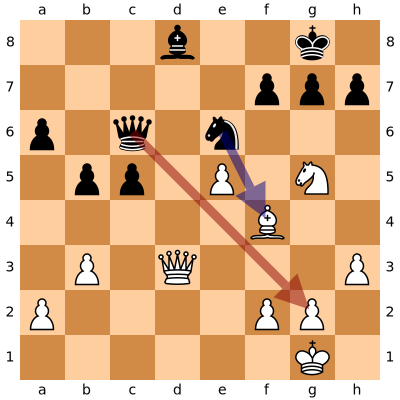

In [722]:
import chess.svg
for i in range(len(bad_fens)):
    fen = bad_fens.values[i]
    move_predicted = chess.Move.from_uci(bad_moves_predicted.values[i])
    move_played = chess.Move.from_uci(bad_moves_played.values[i])
    arrows = [
        chess.svg.Arrow(move_predicted.from_square, move_predicted.to_square, color='#800'),
        chess.svg.Arrow(   move_played.from_square,    move_played.to_square, color='#008')
    ]
    board = chess.Board(fen)
    svg = chess.svg.board(board, arrows=arrows, size=400)
    display(svg)

In [718]:
good_rows = (df_ranks['rank_model'] == 0) & (df_ranks['rank_sf'] > 5)
print(sum(good_rows))
good_fens = df_ranks[good_rows]['board_fen']
good_moves_sf = df_ranks[good_rows]['move_uci_sf']
good_moves_played = df_ranks[good_rows]['move_uci_played']

67


r5k1/P2b4/3bp3/5p2/1P1P3N/4P3/5PPP/RR4K1 b - - 0 28


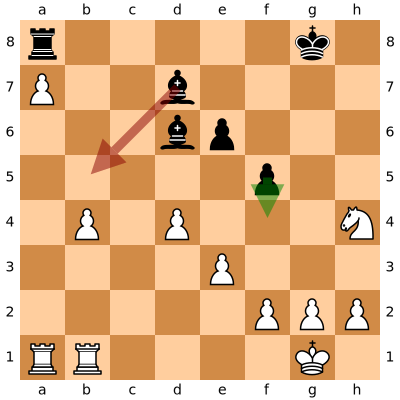

2r5/5ppk/4pn1p/1p6/3Nb2P/3RP3/rP1K1P2/1R6 b - - 7 34


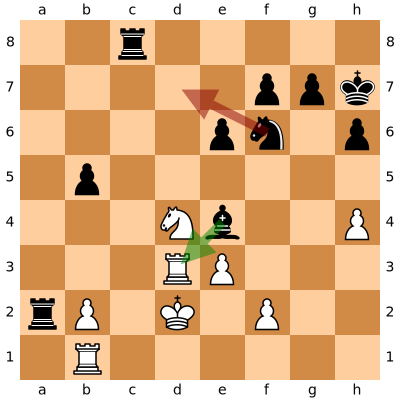

r1bqk1nr/ppppbppp/2n5/4N3/4Q3/8/PPP1PPPP/RNB1KB1R b KQkq - 4 5


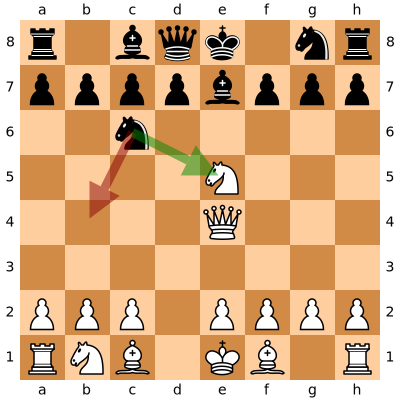

5rk1/5p1p/5qp1/2bPp2n/2r4P/1R3QP1/4NP2/2B2RK1 w - - 1 25


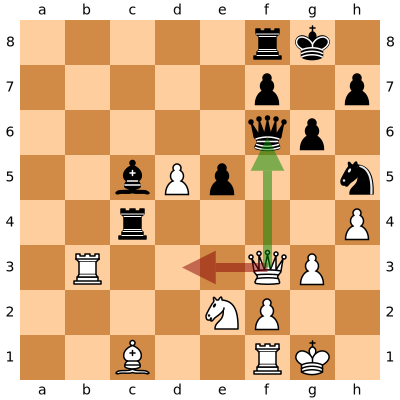

6k1/1p5p/p1pbn1p1/P2p1p2/1PbP4/5K2/8/8 b - - 7 50


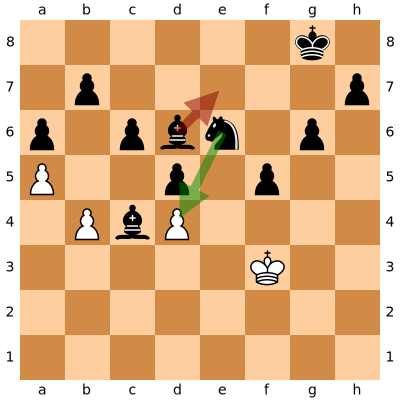

r1b1kb1r/p1p2p1p/np6/4p3/4Pp2/2PB1P2/PP1NN1PP/R2K3R b kq - 3 11


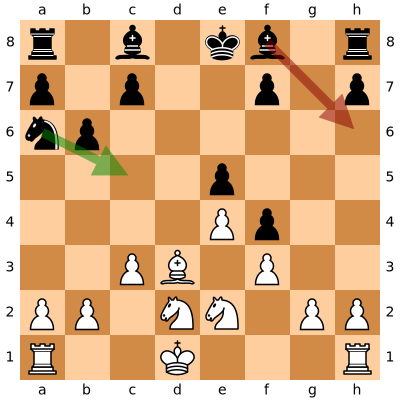

1r6/4kr2/p2p2p1/b1pPp1Pp/n1p1P2P/P1P3N1/RP3PK1/2B2R2 b - - 8 35


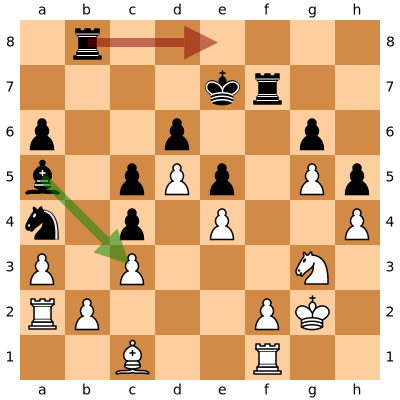

6k1/2pq1bp1/2pb3p/3p1N1P/6P1/r2P1N2/2P5/4Q1RK b - - 1 36


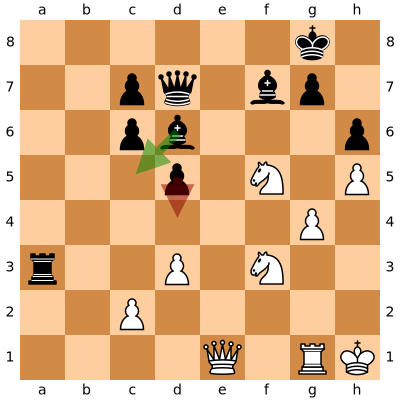

6k1/3q2p1/p1p2p1p/1p6/1P3Q1P/2P3P1/1P3P1K/8 w - - 0 37


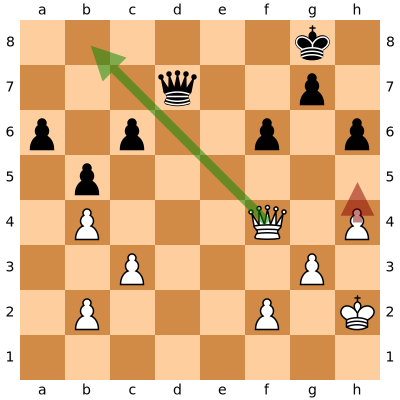

r1q1nrk1/ppnbb1pp/2p1pp2/3pP3/3P1B1P/2P2NP1/PP1NQPB1/2KR3R b - - 1 14


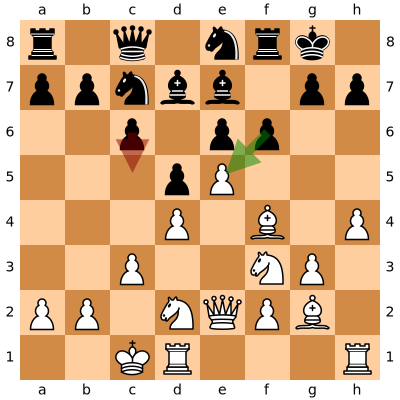

r5k1/1b1q1pb1/p2Brnp1/1PPp3p/3Pp3/1QN1P1NP/5PP1/R3R1K1 b - - 0 26


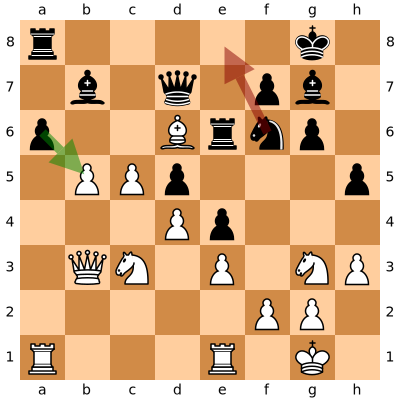

5rk1/6b1/p3bp1p/1p2pN2/3p4/1P6/P1PR2PP/5RK1 b - - 3 29


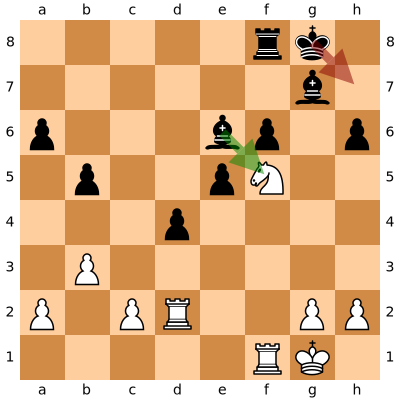

rn2r1k1/1p4b1/p2B4/2pP4/4p3/5P2/PP4P1/R3K1NR w KQ - 0 21


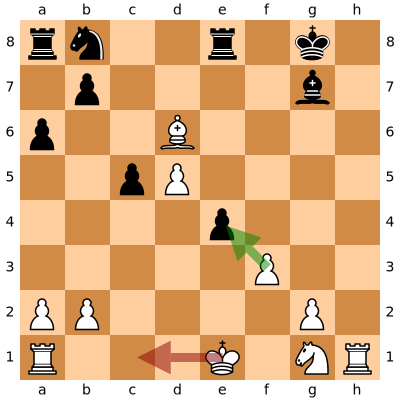

r1bqk2r/2p2ppp/p2b4/1p1pN3/3Pn3/1P6/1PP2PPP/RNBQR1K1 w kq - 1 11


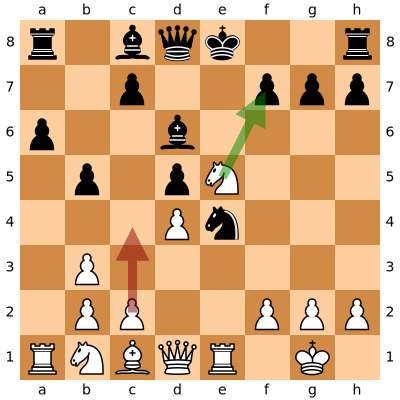

r4rk1/ppp1Rppp/3p4/5b2/2B2B2/8/PPP2PPP/RN4K1 b - - 1 14


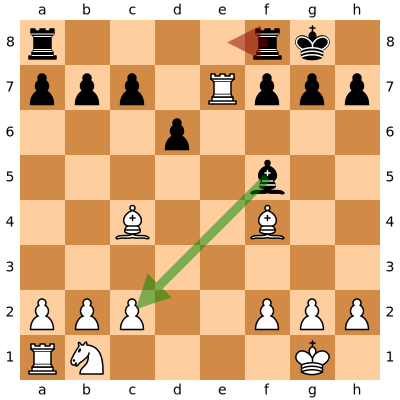

8/1Kp2nkp/1p1p4/p1r5/P5PP/5R2/8/8 b - - 0 39


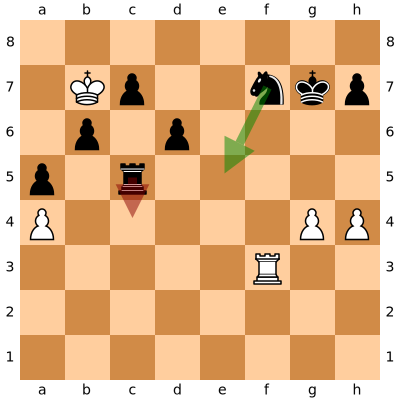

r1b1k1nr/ppp2ppp/1b1p1q2/4p3/2BPP3/2P5/PP3PPP/RNBQ1RK1 w kq - 1 9


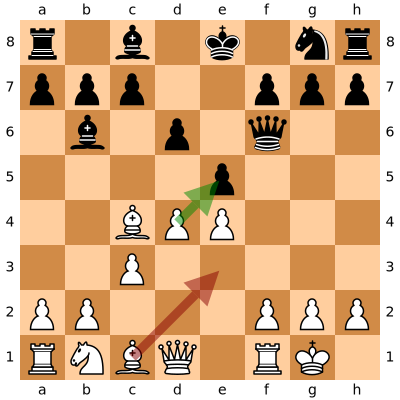

r2qk2r/pppnppbp/3p1np1/8/2B1P3/2NP3P/PPPBQPP1/R3K2R b KQkq - 0 8


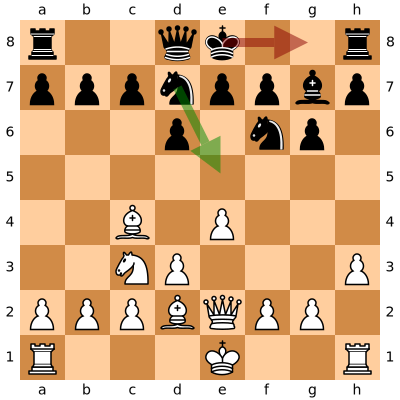

3b4/2k5/1p1p1p2/p2P2p1/1P1BP1nr/P7/2P3RP/4R1K1 w - - 1 30


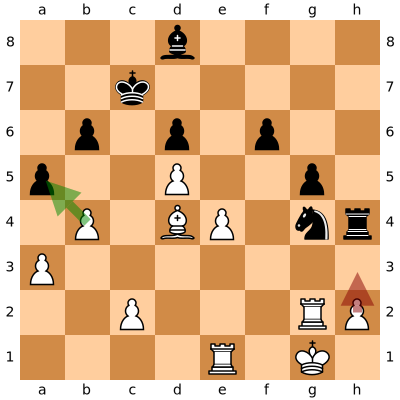

r2qk2r/1pp1npp1/p1b1p2p/b2pP3/3P1P2/N1P1BN2/PP4PP/R2Q1RK1 b kq - 3 11


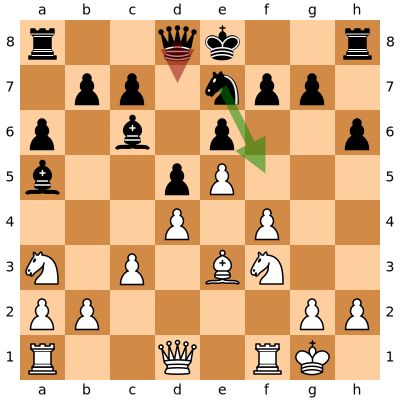

In [719]:
import chess.svg
for i in range(len(good_fens[:20])):
    fen = good_fens.values[i]
    move_sf = chess.Move.from_uci(good_moves_sf.values[i])
    move_played = chess.Move.from_uci(good_moves_played.values[i])
    arrows = [
        chess.svg.Arrow(    move_sf.from_square,     move_sf.to_square, color='#800'),
        chess.svg.Arrow(move_played.from_square, move_played.to_square, color='#080')
    ]
    board = chess.Board(fen)
    svg = chess.svg.board(board, arrows=arrows, size=400)
    print(fen)
    display(svg)

## Performance vs Variables

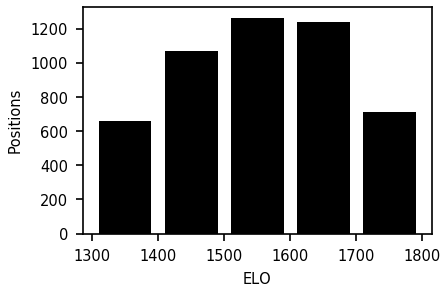

In [460]:
plt.figure(figsize=(3,2))
plt.hist(df_ranks['game_ELO_self'], bins=np.arange(1300, 1801, 100), rwidth=0.8, color='k')
plt.xlabel('ELO')
plt.ylabel('Positions')
plt.show()

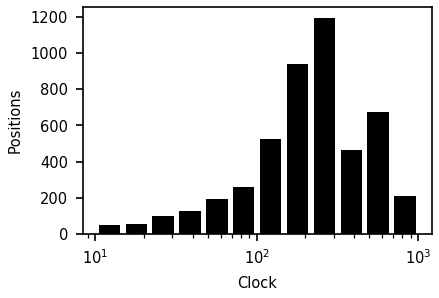

In [512]:
plt.figure(figsize=(3,2))
plt.hist(df_ranks['board_clock_self'], bins=np.geomspace(1e1, 1e3, 13), rwidth=0.8, color='k')
# plt.hist(df_ranks['board_clock_self'], rwidth=0.8, color='k')
plt.xlabel('Clock')
plt.ylabel('Positions')
plt.xscale('log')
plt.show()

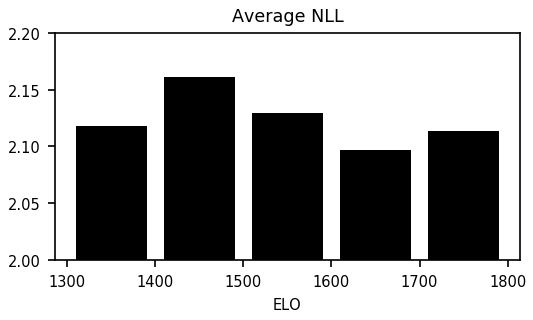

In [742]:
elo_bins = np.arange(1300, 1801, 100)
elo_labels = range(len(elo_bins) - 1)
elo_binned = pd.cut(df_ranks['game_ELO_self'], bins=elo_bins, labels=elo_labels)

plt_x = elo_bins[:-1] + 50
plt_y_sf    = [np.average(-np.log(df_ranks[elo_binned == i]['p_sf'])) for i in elo_labels]
plt_y_model = [np.average(-np.log(df_ranks[elo_binned == i]['p_model'])) for i in elo_labels]
plt.figure(figsize=(4, 2))
plt.bar(plt_x, plt_y_model, width=80, color='k')
plt.ylim(2, 2.2)
# plt.ylim(2.9, 3.1)
plt.title('Average NLL')
plt.xlabel('ELO')
plt.show()

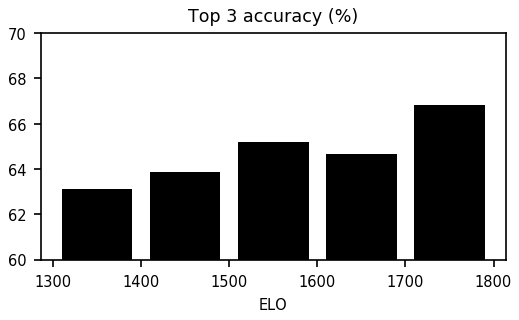

In [750]:
elo_bins = np.arange(1300, 1801, 100)
elo_labels = range(len(elo_bins) - 1)
elo_binned = pd.cut(df_ranks['game_ELO_self'], bins=elo_bins, labels=elo_labels)

plt_x = elo_bins[:-1] + 50
plt_y_sf    = [np.average(df_ranks[elo_binned == i]['rank_sf'] < 3)*100 for i in elo_labels]
plt_y_model = [np.average(df_ranks[elo_binned == i]['rank_model'] < 3)*100 for i in elo_labels]
plt.figure(figsize=(4, 2))
plt.bar(plt_x, plt_y_model, width=80, color='k')
# plt.ylim(2, 2.2)
# plt.ylim(34, 42)
plt.ylim(60, 70)
# plt.ylim(70, 80)
plt.title('Top 3 accuracy (%)')
plt.xlabel('ELO')
plt.show()

In [496]:
# print(df_ranks.columns[:20])
# df_ranks['board_tim']

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id_game', 'id_board',
       'game_time_control_initial', 'game_time_control_increment',
       'game_ELO_self', 'game_ELO_opponent', 'board_fen', 'board_full_moves',
       'board_white_to_move', 'board_clock_self', 'board_clock_opponent',
       'board_clock_used', 'board_check', 'board_can_kingside_castle',
       'board_can_queenside_castle', 'board_number_of_legal_moves',
       'board_attacked_pieces'],
      dtype='object')


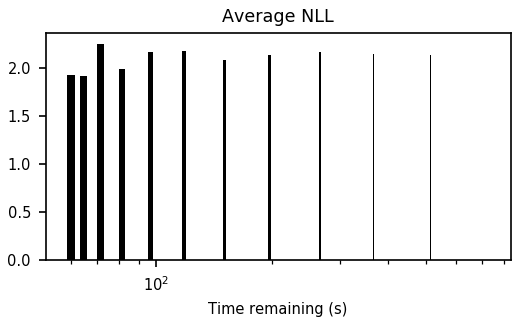

In [532]:
time_bins = np.geomspace(1e1, 1e3, 13)
time_labels = range(len(time_bins) - 1)
time_binned = pd.cut(df_ranks['board_clock_self'], bins=time_bins, labels=time_labels)
# print(time_binned == 2)
# print(time_binned.fillna(20))

plt_x = time_bins[:-1] + 50
plt_y_sf    = [np.average(-np.log(df_ranks[time_binned == i]['p_sf'])) for i in time_labels]
plt_y_model = [np.average(-np.log(df_ranks[time_binned == i]['p_model'])) for i in time_labels]
plt.figure(figsize=(4, 2))
plt.bar(plt_x, plt_y_model, width=3, color='k')
# plt.ylim(2, 2.2)
# plt.ylim(2.9, 3.1)
plt.xscale('log')
plt.title('Average NLL')
plt.xlabel('Time remaining (s)')
plt.show()